### Available connectomes in Conn2Res
 - Dorsal Attention (DA)
 - Default Mode Network (DMN)
 - Frontoparietal (FP)
 - Limbic (LIM)
 - Somatomotor (SM)
 - Ventral Attention (VA)
 - Visual (VIS)

References available via [Zenodo repository](https://zenodo.org/records/10205004)

Sources:
 - [Suarez et al., 2020](https://www.biorxiv.org/content/10.1101/2020.11.10.350876v1.full.pdf)
 - [Dong et al., 2024](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.26575)

In [95]:
# Do the same narrative event segmentation but with a conn2res model instead of a reservoir
# This is a reservoir that utilizes specific connectivity
%matplotlib inline
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

import warnings
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import is_classifier
from conn2res.tasks import Task, NeuroGymTask
from conn2res.connectivity import Conn
from conn2res.reservoir import EchoStateNetwork
from conn2res.readout import Readout
from conn2res import readout, plotting
from tqdm import tqdm
import reservoirpy as rpy
import matplotlib.patches as patches

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# Need to build task, which is the Narrative event segmentation task using the wikipedia2vec embeddings of narrative

# set up

from wikipedia2vec import Wikipedia2Vec
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

np.random.seed(4)
vectorDim = 100

numNode = 500


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ijackson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# get training data and task
in_small = '/home/ijackson/dynamics/sandbox/Narrative-Integration-Reservoir/in_small.npy'
out_small = '/home/ijackson/dynamics/sandbox/Narrative-Integration-Reservoir/out_small.npy'
wiki2vec = Wikipedia2Vec.load('/home/ijackson/dynamics/sandbox/enwiki_20180420_100d.pkl')

#read in the narrative

huge_list = []

#with open("my_file_Gatsby_Kane_wolfe_bond.txt", "r") as f:
#    huge_list = f.read().split()::::"iss_gatsby_long.txt"
#with open("iss_gatsby_nfl_long.txt", "r", encoding="utf8") as f:
with open("/home/ijackson/dynamics/sandbox/Narrative-Integration-Reservoir/not-the-fall.txt", "r", encoding="utf8") as f:
    huge_list = f.read().split()

discourse_words = huge_list

# need to train reservoir on this data

In [ ]:
# clean it up
# large capital -> small capital

discourse_words = [s.replace(s, s.lower()) for s in discourse_words]

    # remove '.' and ',' from word list
discourse_words = [s.replace('.', '') for s in discourse_words]
discourse_words = [s.replace(',', '') for s in discourse_words]

    # remove stop words from word list
stop_words = stopwords.words('english')
    #print(stop_words)
for stop_word in tqdm(stop_words):
    while stop_word in discourse_words :
        discourse_words.remove(stop_word)
            
    # remove "'s" and "'" and "-" and "'d" and "'ll" and "'ve" and "re" from word list
discourse_words = [s.replace("'s", '') for s in discourse_words]
discourse_words = [s.replace("'", '') for s in discourse_words]
discourse_words = [s.replace("-", ' ') for s in discourse_words]
discourse_words = [s.replace("'d", '') for s in discourse_words]
discourse_words = [s.replace("'ll", '') for s in discourse_words]
discourse_words = [s.replace("'ve", '') for s in discourse_words]
discourse_words = [s.replace("'re", '') for s in discourse_words]
discourse_words = [s.replace("(", '') for s in discourse_words]
discourse_words = [s.replace(")", '') for s in discourse_words]
discourse_words = [s.replace("[", '') for s in discourse_words]
discourse_words = [s.replace("]", '') for s in discourse_words]
discourse_words = [s.replace(",", '') for s in discourse_words]
discourse_words = [s.replace(";", '') for s in discourse_words]
discourse_words = [s.replace("-", '') for s in discourse_words]
discourse_words = [s.replace(":", '') for s in discourse_words]
discourse_words = [s.replace("?", '') for s in discourse_words]
discourse_words = [s.replace("!", '') for s in discourse_words]


100%|██████████| 179/179 [00:00<00:00, 9933.32it/s]


In [6]:
inputDataTesting = np.empty((0,vectorDim))
print(inputDataTesting.shape)

for num in range(len(discourse_words)):
    inputDataTesting = np.append(inputDataTesting, np.array([wiki2vec.get_word_vector(discourse_words[num])]), axis=0)
    # print(discourse_words[num], num, end = ' ')
print('\n'+str(inputDataTesting.shape))

(0, 100)

(682, 100)


In [7]:
consensus_0 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_0.npy')
consensus_1 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_1.npy')
consensus_2 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_2.npy')
consensus_3 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_3.npy')
consensus_4 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_4.npy')
consensus_5 = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/consensus_5.npy')
coords = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/coords.npy') # coordinates for each node
cortical = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/cortical.npy') # a 0 or 1 for each node indicating cortical or subcortical?
hemiid = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/hemiid.npy') # a 0 or 1 for each node indicating hemisphere
rsn_mapping = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/rsn_mapping.npy') # network assignment for each node
connectivity = np.load('/home/ijackson/dynamics/conn2res/examples/data/human/connectivity.npy') # connectivity matrix for 70 subjects

print("Shape of consensus_0: ", consensus_0.shape)
print("Shape of consensus_1: ", consensus_1.shape)
print("Shape of consensus_2: ", consensus_2.shape)
print("Shape of consensus_3: ", consensus_3.shape)
print("Shape of consensus_4: ", consensus_4.shape)
print("Shape of consensus_5: ", consensus_5.shape)
print("Shape of coords: ", coords.shape)
print("Shape of cortical: ", cortical.shape)
print("Shape of hemiid: ", hemiid.shape)
print("Shape of rsn_mapping: ", rsn_mapping.shape)
print("Shape of connectivity: ", connectivity.shape)

Shape of consensus_0:  (1015, 1015)
Shape of consensus_1:  (1015, 1015)
Shape of consensus_2:  (1015, 1015)
Shape of consensus_3:  (1015, 1015)
Shape of consensus_4:  (1015, 1015)
Shape of consensus_5:  (1015, 1015)
Shape of coords:  (1015, 3)
Shape of cortical:  (1015,)
Shape of hemiid:  (1015,)
Shape of rsn_mapping:  (1015,)
Shape of connectivity:  (1015, 1015, 70)


In [42]:
# Build comparison reservoir using reservoirpy

rpy.verbosity(0)
rpy.set_seed(42)
# nNeurons = vectorDim
learning_rate = 0.05 # leak rate
spectral_radius = 1 # maximum absolute eigenvalue of the reservoir matrix
# feedback?
rpy_res = rpy.nodes.Reservoir(vectorDim, lr=learning_rate, sr=spectral_radius)

In [83]:
# Build reservoir using Conn2Res

# this would probably just be better as an extension of the ESN class in Conn2Res
class ConnRes:
    # a reservoir that uses connectivity data to define connections between nodes
    def __init__(self, connectivity, nodes_path, network, nNeurons, alpha=1.0, ACT_FCN='tanh', leak_rate=0.05, seed=42, wBias=0):
        # self.connectivity = connectivity
        # self.nodes_path = nodes_path
        self.network = network
        self.nNeurons = nNeurons
        # self.alpha = alpha
        # self.activation = ACT_FCN
        # self.leak_rate = leak_rate
        # self.seed = seed
        # self.wBias = wBias
        try:
            self.input_nodes = connectivity.get_nodes(
                'random', nodes_from=connectivity.get_nodes(network,filename=nodes_path),
                n_nodes=nNeurons, seed=seed)
        except Exception as e:
            print(e)
            raise ValueError('Error in getting input nodes')
        self.w_in = np.zeros((nNeurons, conn.n_nodes))
        self.w_in[:, self.input_nodes] = np.eye(nNeurons)
        self.esn = EchoStateNetwork(w=connectivity.w + wBias, activation_function=ACT_FCN, leak_rate = leak_rate)
        self.esn.w = self.esn.w * alpha # scale the connectivity matrix by alpha to adjust the spectral radius
        self.sim_states = [] # store the reservoir states for each input
        self.HMM_bounds = [] # store the boundaries from HMM segmentation

In [84]:
# load connectivity data of one subject
connectivity_path = '../conn2res/examples/data/human/connectivity.npy'
conn = Conn(filename=connectivity_path, subj_id=0)

# scale conenctivity weights between [0,1] and normalize by spectral radius
conn.scale_and_normalize() # this makes the spectral radius 1, which we can modify with alpha later

# get path of network labels for each node
nodes_path = '../conn2res/examples/data/human/rsn_mapping.npy'

seed = 1390 # 42
wBias = 0 # bias for the weights (- 0.0045 seems to find the best results)
connectivity = conn # Conn2Res connectivity object
activation = 'tanh' # activation function defines local dynamics

connResToTest = {'SM': None, 'DMN': None, 'VIS': None, 'VA': None}
for network in connResToTest:
    connResToTest[network] = ConnRes(conn, nodes_path, network, vectorDim, seed=seed, wBias=wBias) # the second element is the output states

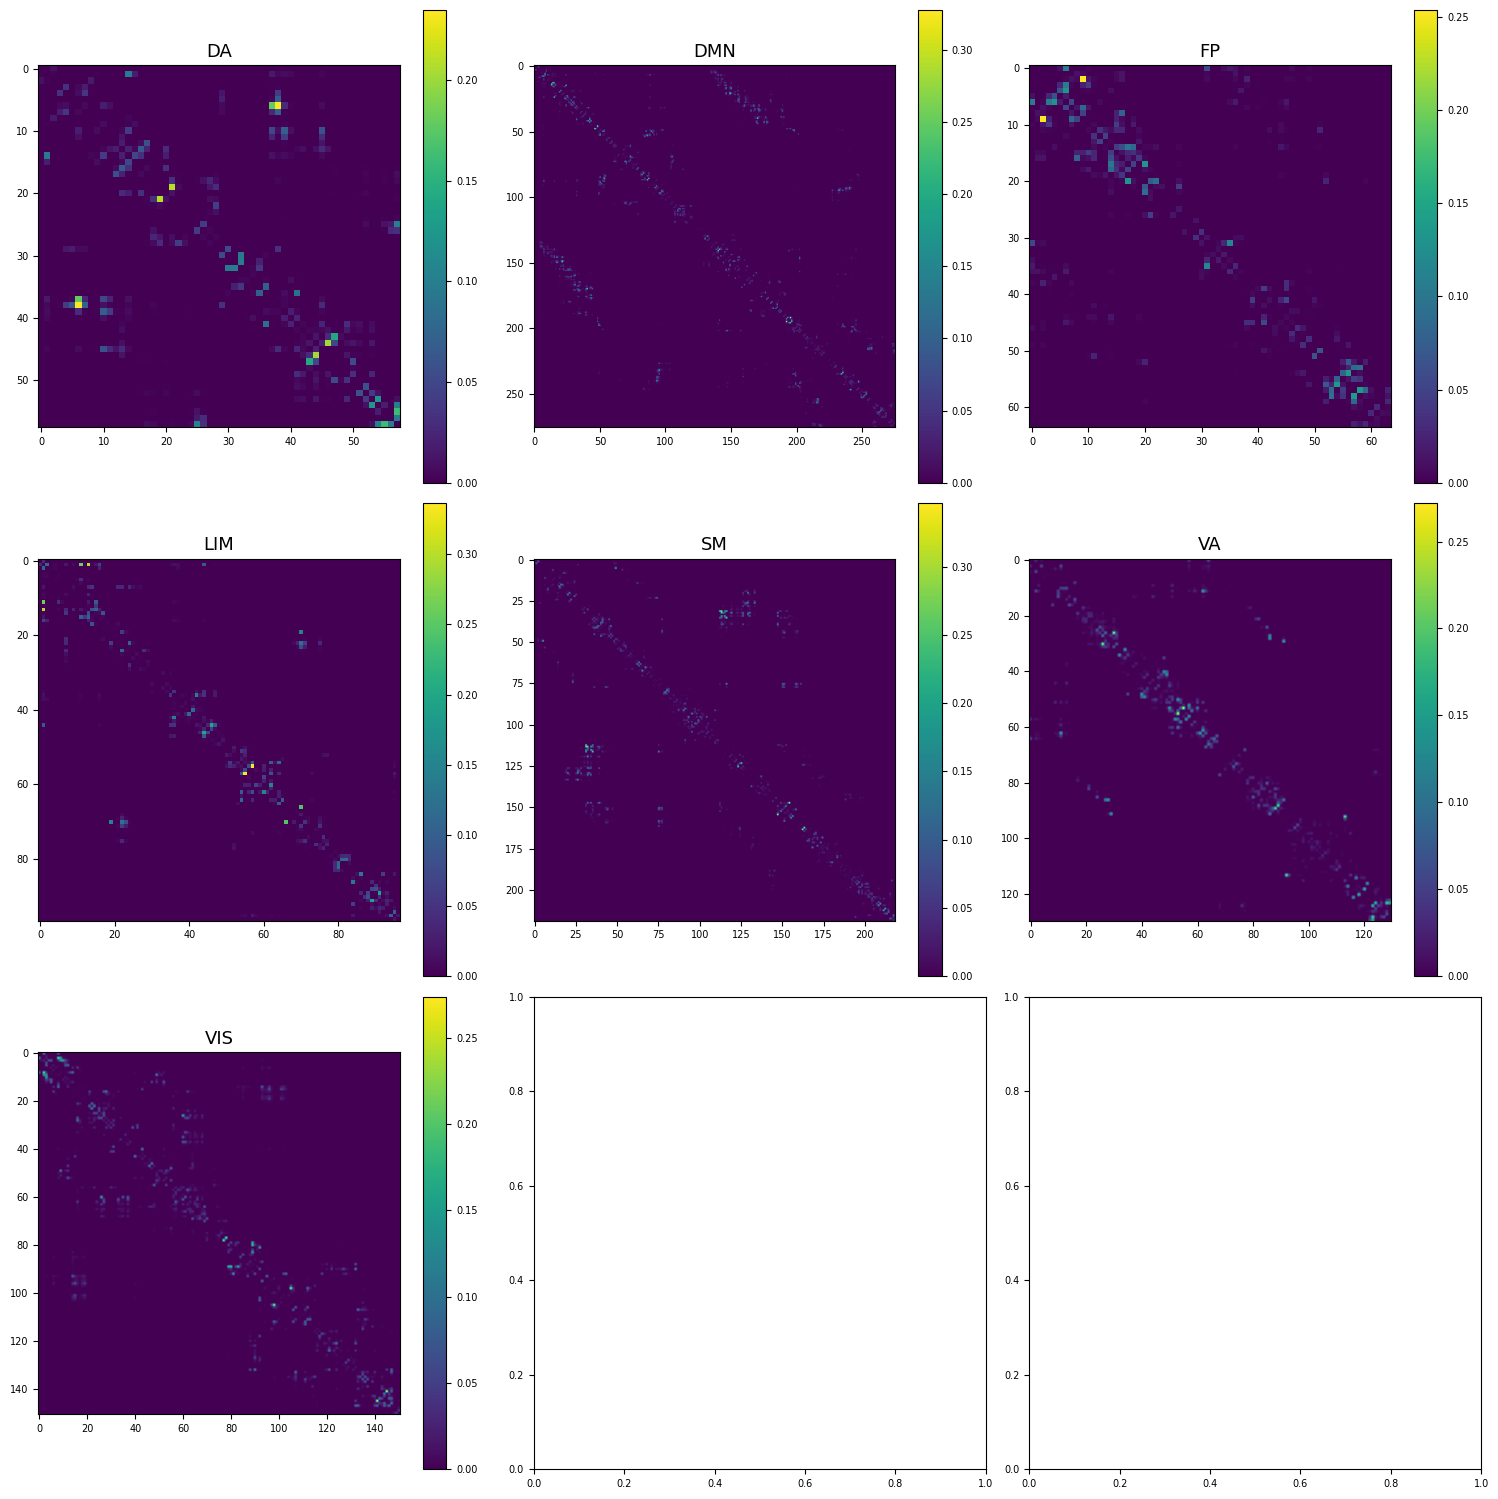

In [85]:
# Plot the connectivity matrix for each network

networks = {"DA":"Dorsal Attention","DMN":"Default Mode Network","FP":"Frontoparietal","LIM":"Limbic","SM":"Somatomotor","VA":"Ventral Attention","VIS":"Visual"}
# 15 subctx regions in rsn_mapping but they don't show up in the connectivity matrix and there are none in any of the networks

# plot connectivity matrix in a 3x3 subplots for each network
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, network in enumerate(networks):
    try:
        nodes = conn.get_nodes(network,filename=nodes_path)
    except:
        print(f"Network {network} not found in the connectivity matrix")
    in_network_connectivity = conn.w[np.ix_(nodes,nodes)]
    plt.subplot(3,3,i+1)
    plt.imshow(in_network_connectivity)
    plt.title(network, fontsize=13)
    plt.colorbar()

#plt.suptitle("Connectivity for Each Network in Conn2Res", fontsize=13)
# add a little spacing between title and subplots
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
plt.show()

In [86]:
# check the connectivity matrix of the input nodes
# plt.imshow(conn.w[np.ix_(input_nodes, input_nodes)])
# plt.colorbar()

In [87]:
# Collect states from rpy reservoir
res_states = []
# get reservoir states for each brain state
# reset = True
rpy_res_states = rpy_res.run(inputDataTesting)

In [88]:
rpy_res_states.shape
# prediction ESN has a different number of input nodes than it does neurons in the reservoir
# how does it handle this and how can we implement in the conn2res model?

# prediction ESN also ends up with a 682 (time) by 601 matrix of states, why? it was initialized with 500 neurons. and dominey cuts it down to 500

(682, 100)

In [89]:
# Collect states from the connres reservoir

print("Collecting states from the connres reservoirs of interest.")
for network in tqdm(connResToTest):
    print(f"Collecting states for network {network}")
    connResToTest[network].sim_states = connResToTest[network].esn.simulate(
        ext_input=inputDataTesting, w_in=connResToTest[network].w_in,
        output_nodes=connResToTest[network].input_nodes
    )

  0%|          | 0/4 [00:00<?, ?it/s]

	 ----- timestep = 100
	 ----- timestep = 200
	 ----- timestep = 300


 25%|██▌       | 1/4 [00:00<00:00,  3.32it/s]

	 ----- timestep = 400
	 ----- timestep = 500
	 ----- timestep = 600
	 ----- timestep = 100
	 ----- timestep = 200
	 ----- timestep = 300


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

	 ----- timestep = 400
	 ----- timestep = 500
	 ----- timestep = 600
	 ----- timestep = 100
	 ----- timestep = 200
	 ----- timestep = 300
	 ----- timestep = 400


 75%|███████▌  | 3/4 [00:00<00:00,  2.89it/s]

	 ----- timestep = 500
	 ----- timestep = 600
	 ----- timestep = 100
	 ----- timestep = 200
	 ----- timestep = 300
	 ----- timestep = 400
	 ----- timestep = 500


100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

	 ----- timestep = 600


In [90]:
# import states from original NIR code
states = np.load('./reservoirStatesBuffer.npy')

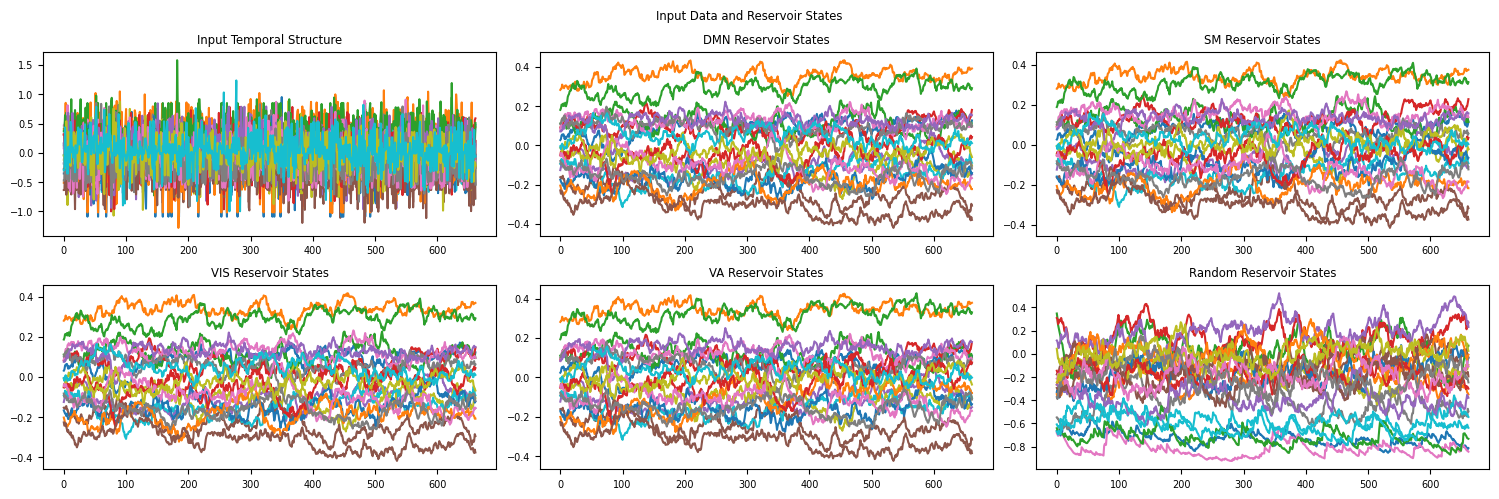

In [91]:
# plot the reservoir states against the input data states side by side
resn = 20
begin = 20
end = 682

fig = plt.figure(figsize=(15, 5))
plt.subplot(2,3,1)
plt.plot(inputDataTesting[begin:end,:resn])
plt.title('Input Temporal Structure')

plt.subplot(2,3,2)
plt.plot(connResToTest['DMN'].sim_states[begin:end,:resn])
plt.title('DMN Reservoir States')

plt.subplot(2,3,3)
plt.plot(connResToTest['SM'].sim_states[begin:end,:resn])
plt.title('SM Reservoir States')

plt.subplot(2,3,4)
plt.plot(connResToTest['VIS'].sim_states[begin:end,:resn])
plt.title('VIS Reservoir States')

plt.subplot(2,3,5)
plt.plot(connResToTest['VA'].sim_states[begin:end,:resn])
plt.title('VA Reservoir States')

plt.subplot(2,3,6)
plt.plot(states[begin:end,:resn])
plt.title('Random Reservoir States')

plt.suptitle("Input Data and Reservoir States")
fig.tight_layout()
plt.show()


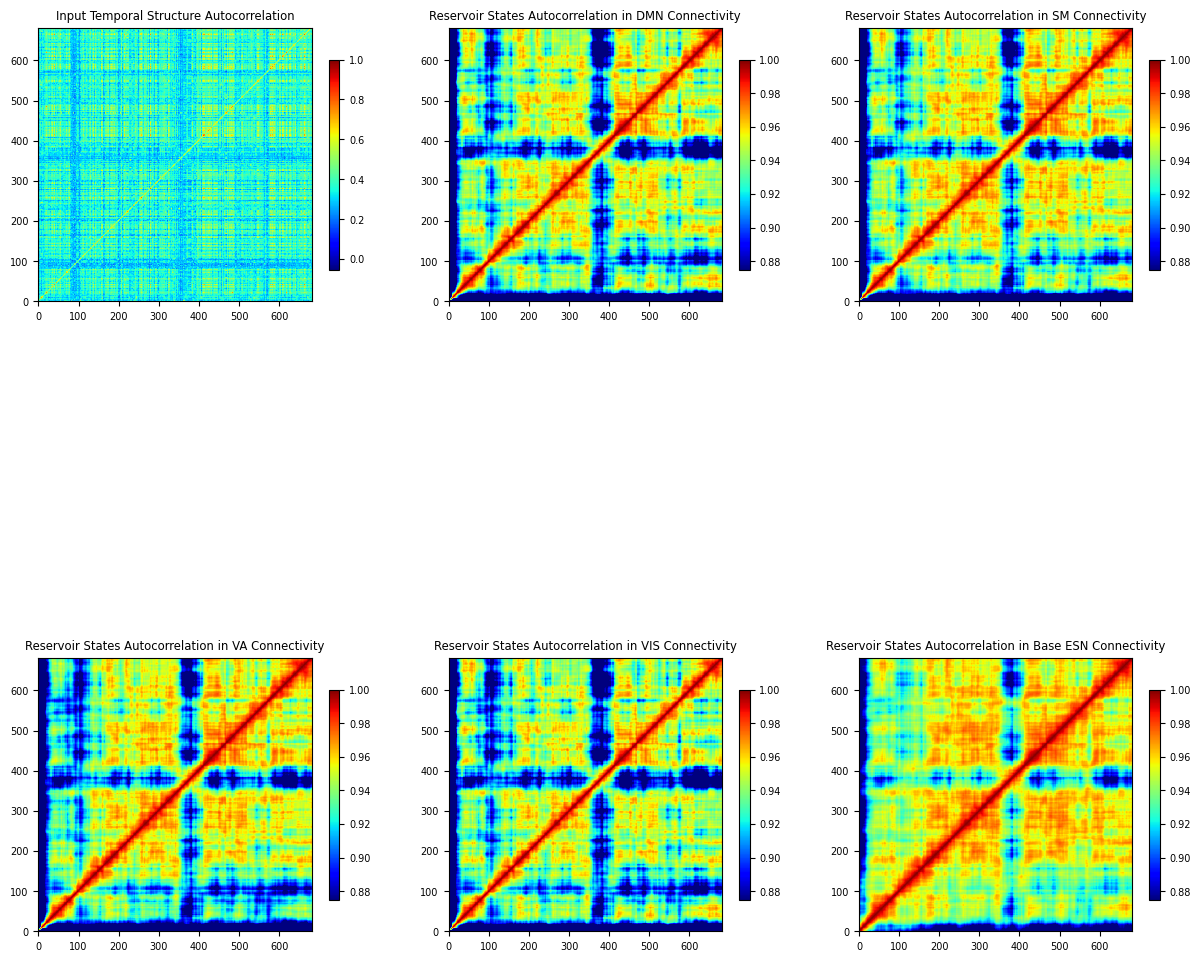

In [92]:
fig = plt.figure(figsize=(15,15))

# plot the autocorrelation of the input data
plt.subplot(2,3,1)
plt.imshow(np.corrcoef(inputDataTesting),  cmap='jet',origin='lower')
plt.colorbar(shrink=0.4)
plt.title('Input Temporal Structure Autocorrelation')

# plot the autocorrelation of the dmn states
plt.subplot(2,3,2)
plt.imshow(np.corrcoef(connResToTest['DMN'].sim_states), cmap='jet',  vmin=0.875, vmax=1,origin='lower')
plt.colorbar(shrink=0.4)
plt.title(f'Reservoir States Autocorrelation in DMN Connectivity')

# plot the autocorrelation of the sm states
plt.subplot(2,3,3)
plt.imshow(np.corrcoef(connResToTest['SM'].sim_states), cmap='jet',  vmin=0.875, vmax=1,origin='lower')
plt.colorbar(shrink=0.4)
plt.title(f'Reservoir States Autocorrelation in SM Connectivity')

plt.subplot(2,3,4)
# plot the autocorrelation of the va states
plt.imshow(np.corrcoef(connResToTest['VA'].sim_states), cmap='jet',  vmin=0.875, vmax=1,origin='lower')
plt.colorbar(shrink=0.4)
plt.title(f'Reservoir States Autocorrelation in VA Connectivity')


plt.subplot(2,3,5)
# plot the autocorrelation of the vis states
plt.imshow(np.corrcoef(connResToTest['VIS'].sim_states), cmap='jet',  vmin=0.875, vmax=1,origin='lower')
plt.colorbar(shrink=0.4)
plt.title(f'Reservoir States Autocorrelation in VIS Connectivity')


plt.subplot(2,3,6)
# plot the autocorrelation of the rpy states
plt.imshow(np.corrcoef(states),vmin=0.875, vmax=1,origin='lower',cmap='jet')
#plt.gca().invert_yaxis()
plt.colorbar(shrink=0.4)
plt.title(f'Reservoir States Autocorrelation in Base ESN Connectivity')
# make a common colorbar among the subplots

# fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=fig.get_axes(), orientation='horizontal', fraction = 0.05, pad = 0.1)
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=fig.get_axes(), orientation='horizontal', location='bottom', boundaries=[0.875, 1])
# cbar.boundaries = [0.875, 1]

plt.tight_layout(rect=[1,0.1,1,1])

# plt.savefig('reservoir-states-autocorr.png',dpi=600)

In [93]:
'''Questions

2. Why is the autocorrelation of the input data so low?
3. Does taking the states of esn.predict actually use any of the training from esn.fit in EasyESN?
4. Some networks don't have enough nodes for inputs from Wikipedia2Vec embeddings. How do we handle this?
5. How to control the criticality mentioned in Suarez et al., 2020?
6. What's next?
 - Segment states
 - Look at context construction and forgetting
 - Look at alignment times
'''

"Questions\n\n2. Why is the autocorrelation of the input data so low?\n3. Does taking the states of esn.predict actually use any of the training from esn.fit in EasyESN?\n4. Some networks don't have enough nodes for inputs from Wikipedia2Vec embeddings. How do we handle this?\n5. How to control the criticality mentioned in Suarez et al., 2020?\n6. What's next?\n - Segment states\n - Look at context construction and forgetting\n - Look at alignment times\n"

In [94]:
# segment the states with the HMM from Baldassano (2017)
import brainiak.eventseg.event
nEvents = 12
nTR = 682
bounds = []
for network in tqdm(connResToTest):
    print(f"Segmenting states for network {network}")
    # 12 is the number of events for NTF, according to source github repo
    ev = brainiak.eventseg.event.EventSegment(nEvents)
    ev.fit(connResToTest[network].sim_states)
    bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
    bounds_aug = np.concatenate(([0],bounds,[nTR]))
    connResToTest[network].bounds = bounds_aug


Segmenting states for network SM
Segmenting states for network DMN
Segmenting states for network VIS
Segmenting states for network VA


In [96]:
# segment reservoir states
bounds = []
ev = brainiak.eventseg.event.EventSegment(nEvents)
ev.fit(states)
bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
bounds_aug = np.concatenate(([0],bounds,[nTR]))

In [103]:
print(connResToTest['DMN'].bounds)
print(connResToTest['SM'].bounds)

[  0  36  89 166 219 260 338 410 465 521 578 627 682]
[  0  36  91 166 219 260 337 410 465 520 577 625 682]


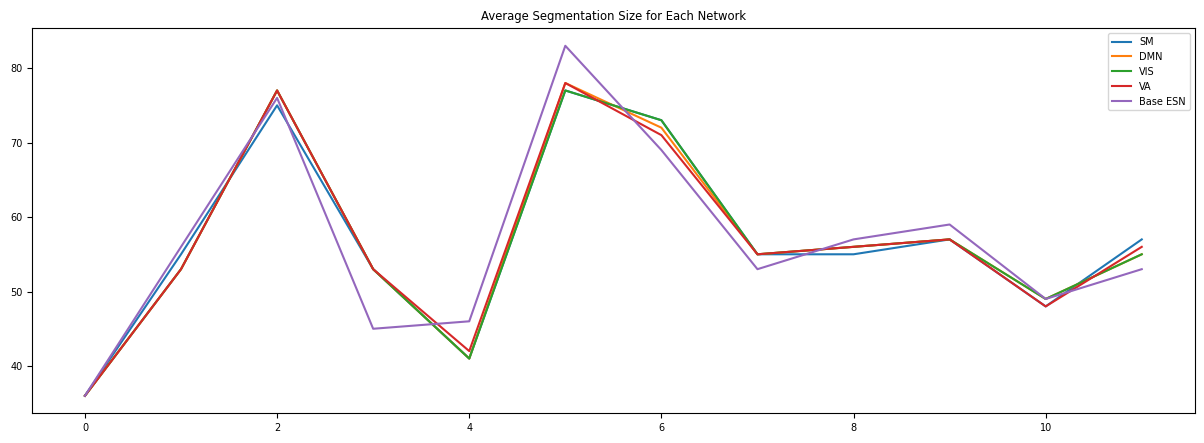

In [100]:
# first just plot the average boundary size for each network

# plot the average boundary size for each network and the base ESN in one plot
fig = plt.figure(figsize=(15, 5))

for network in connResToTest:
    plt.plot(np.diff(connResToTest[network].bounds), label=network)
plt.plot(np.diff(bounds_aug), label='Base ESN')
plt.title('Average Segmentation Size for Each Network')
plt.xlabel('Segment Index')
plt.ylabel('Segment Size')
plt.legend()
plt.show()

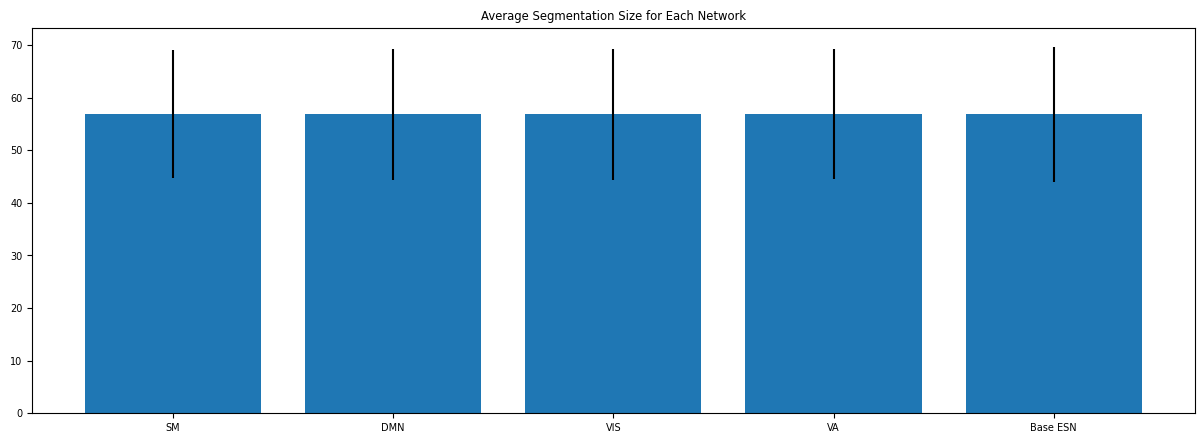

In [102]:
# now a bar plot of the average boundary size for each network and the base ESN

fig = plt.figure(figsize=(15, 5))

networks = list(connResToTest.keys())
networks.append('Base ESN')
boundary_sizes = []
for network in connResToTest:
    boundary_sizes.append(np.mean(np.diff(connResToTest[network].bounds)))
boundary_sizes.append(np.mean(np.diff(bounds_aug)))
plt.bar(networks, boundary_sizes)
plt.title('Average Segmentation Size for Each Network')
# add bars for standard deviation
plt.errorbar(networks, boundary_sizes, yerr=[np.std(np.diff(connResToTest[network].bounds)) for network in connResToTest] + [np.std(np.diff(bounds_aug))], fmt='none', color='black')
plt.show()

In [ ]:
# plot them all in subplots

fig = plt.figure(figsize=(15,15))

# plot for input data
plt.subplot(2,3,1)
plt.imshow(np.corrcoef(inputDataTesting),  cmap='jet',origin='lower')
ax = plt.gca()
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
plt.colorbar(shrink=0.4)
plt.title('Input Temporal Structure Segmented Autocorrelation')

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

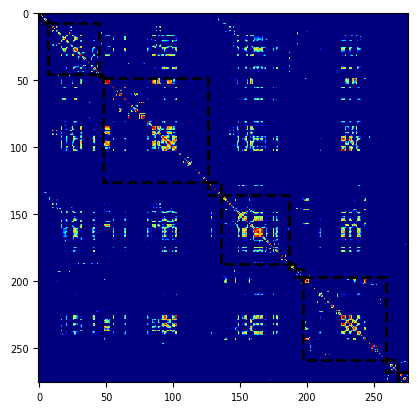

In [94]:
# show the boundaries
import matplotlib.patches as patches
color='jet'
edge='black'
scale1=0.825
scale2=0.9
# plt.figure(figsize=(10, 5))
plt.imshow(np.corrcoef(rs_test),vmin=scale1, cmap=color)
ax = plt.gca()
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
